# Homework 3

### This is the solution of:
* Klas Henriksson klhe0017@student.umu.se
* Joel Nilsson joni
* Daniel Dahlgren Lindström dali


The same general rules as for Homework 1 applies.

$$\newcommand{\dx}{\,\mathrm{d}x}
\newcommand{\ldb}{\left\llbracket}
\newcommand{\rdb}{\right\rrbracket}
\newcommand{\lp}{\left(}
\newcommand{\rp}{\right)}
\newcommand{||}{|\mspace{-1mu}|\mspace{-1mu}|}
\newcommand{\IR}{\mathbb{R}}
$$

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./custom-style.css", "r").read()
    return HTML(styles)

# Comment out next line and execute this cell to restore the default notebook style 
css_styling()

## Problem 1 ($L^2$-projection)


Let $0 = x_0 < x_1 < x_2 < \ldots < x_{N} = 1$ be a partition of the interval
$I = (0,1)$ into $N$ subintervals of equal length $h=1/N$.  Moreover,
let $\{ \lambda_j\}_{j=0}^{N}$ be the set of nodal/hat basis functions of $V_h$
associated with the $N+1$ nodes $x_j$, $j = 0,1\ldots, N$, such that
The $L^2$-projection reads: find $P_hf\in V_h$ such that
$$
    \int_I(f - P_h f) v dx = 0 \qquad\text{for all }v\in V_h
$$
We consider three different functions
* $f_1(x)=x\sin (3\pi x)$
* $f_2(x)=2-10x$
* $f_3(x)=x(1-x)$

**a)** Write a script ${\texttt {AssembleMassMatrix1D(x)}}$ that computes the mass matrix. 

**b)** Write a corresponding function $\texttt{AssembleLoadVector(x,f)}$ which computes 
the load vector for a given function $f$. Make sure that you can easily switch (for example by adding another input variable) out the quadrature
rule (Trapezoid and Simpson) to approximate the integrals $\int_{I} f \varphi_i dx$

Convince yourself that your code is correct by computing the $L^2$ projection of the given functions, and observe that they look similar to the original function when plotting in the same figure (with enough mesh points). You do not need to document this.

**c)** Write a function $\texttt{ComputeErrorL2(x,Pf,f)}$ which computes the error in $L^2$ norm, 
$$\|P_h f-f \|=\sqrt{\int_0^1(P_h f-f)^2 dx}.$$
Hint: use the equivalent formula
$$\|P_h f-f \|=\sqrt{\sum_{i=1}^{N} \int_{x_{i-1}}^{x_{i}}(P_h f-f)^2 dx},$$
and approximate the integrals in each subinterval using Simpson's rule.

**d)** Test your code by computing the $L^2$-projection $P_h f\in V_h$ for the three given functions by using the
Trapezoidal rule to compute the load vector. Test with different $N$ values. Do the errors converge as expected?

**e)** Repeat **d)** using Simpson's rule to compute the load vector. What do you find and why?

### Code Snippets

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def AssembleMassMatrix1D(x):
    # Number of intervals
    N = x.size-1
    # 1) Allocate and initiate matrix
    M = np.zeros((x.size, x.size))

    # 2) Compute volume contributions by iterating over 
    #    intervals I_0 to I_(N-1):
    for i in range(0,N):
        # Mesh  size
        h = x[i+1] - x[i]
        # Compute local mass matrix
        M_loc = h/6*np.array([[2, 1],[1, 2]])
        # Write local matrix into global
        M[i, i] += M_loc[0, 0]
        M[i,i+1] += M_loc[0,1]
        M[i+1, i] += M_loc[1,0]
        M[i+1, i+1] += M_loc[1,1]
    
    return M

In [3]:
def AssembleLoadVector1D(x, f, integ_method):
    # Number of intervals
    N = x.size - 1
    # 1) Allocate and initiate global load vector
    b = np.zeros((x.size,1))
    # 2) Compute volume contributions by iterating over intervals 
    #    I_1 to I_N:
    for i in range(0,N):
        # Mesh  size
        h = x[i+1] - x[i]
        # Element load vector
        b_loc = np.zeros(2)

        if integ_method == 'trapezoid':
            # Apply quadrature rule to int f phi_{i-1} and int f phi_{i}
            # Trapezoidal
            b_loc[0] = f(x[i])*h/2
            b_loc[1] = f(x[i+1])*h/2
        elif integ_method == 'simpsons':
            # Simpson
            #if i == 0:
            #    m = (x[i+1]+x[i])/2
            #    b_loc[0] = (f(x[i]) + 4*f(x[m])*0.5)
            #    b_loc[1] = 0
            #else:
            #m_1 = (x[i] + x[i-1])/2
            #m_2 = (x[i+1] + x[i])/2

            #b_loc[0] = (4 * f(m_1)*0.5 + f(x[i])) * h/6
            #b_loc[1] = (4 * f(m_2)*0.5 + f(x[i])) * h/6

            #b0 = (f(x0) + 4*f((x1)/2)) * h/6
            #b1 = (4 * (f(x1+x0)/2)*0.5 + f(x1) + f(x1) + 4*(f((x2+x1)/2))*0.5) * h/6
            #b2 = (4 * f(x2+x1)/2) * 0.5 + f(x2) + f(x2) + 4*(f((x3+x2)/2))*0.5) * h/6
            #bN = (4 * f(xn-1 + xn)/2) * 0.5 + f(xn)) * h/6

            b_loc[0] = (f(x[i]) + 4 * f( (x[i+1] + x[i])/2 )*0.5) * h/6
            b_loc[1] = (4 * f( (x[i+1] + x[i])/2 )*0.5 + f(x[i+1])) * h/6

            #b_loc[1] (i=0) + b_loc[0] (i=1) = b[1]
        
        # Add to global vector
        b[i] += b_loc[0]
        b[i+1] += b_loc[1]

    return b

In [4]:
def ComputeErrorL2(x,Pf,f):
    # Pf is an arracy consisting of the L2 projection evaluated on the mesh points
    # f is a function for f1, f2 or f3
    N = Pf.size-1
    err = 0
    for i in range(N):
        h = x[i+1]-x[i]
        Pfl = Pf[i] # L2 projection value at x[i]
        Pfr = Pf[i+1] # L2 projection value at x[i+1]
        fl = f(x[i]) # function value at x[i]
        fr = f(x[i+1]) # function value at x[i+1]
        m = (x[i]+x[i+1])/2
        
        e_l = (Pfl - fl)**2;
        e_r = (Pfr - fr)**2;
        e_m = ((Pfr + Pfl)/2 - f(m))**2; #WTF??
        err = err + (e_l + 4*e_m * e_r)*h/6 # Simpsons rule
        #print(err)
    return np.sqrt(err) # hint: ... is not just err

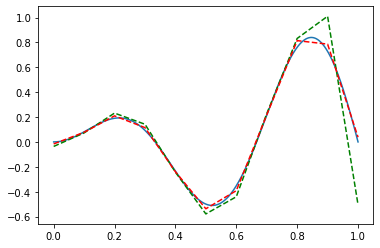

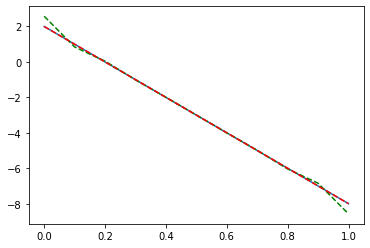

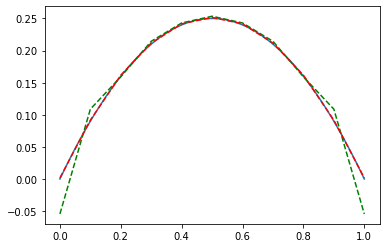

In [5]:
f1 = lambda x : x * np.sin(3 * np.pi * x)
f2 = lambda x : 2 - 10 * x
f3 = lambda x : x * (1-x)
fs = [f1,f2,f3]

for f in fs:
    N = 10
    x = np.linspace(0, 1, N+1)

    M = AssembleMassMatrix1D(x)
    b_trapz = AssembleLoadVector1D(x, f, 'trapezoid')
    b_simps = AssembleLoadVector1D(x, f, 'simpsons')

    Pf_trapz = np.linalg.solve(M,b_trapz)
    Pf_simps = np.linalg.solve(M,b_simps)

    error_trapz = ComputeErrorL2(x, Pf_trapz, f)
    error_simps = ComputeErrorL2(x,Pf_simps, f)

    x_analytic = np.linspace(0,1,1000)
    plt.plot(x_analytic, f(x_analytic))
    plt.plot(x,Pf_trapz,'g--')
    plt.plot(x,Pf_simps, 'r--')
    plt.show()

## Problem 2  (The variational/weak formulation of Poisson's equation)

Note: Problem 2 is a theoretical exercise. You are not required to write any programming code.

**a)**
Using integration by parts, derive a weak formulation for the problem 
\begin{align*}
- (a(x)u(x)')' + c(x)u(x) = f \quad \text{in } I = (0,1)
\\
u(0) = g(0), \quad u(1) = g(1),
\end{align*}
for two smooth functions $a(x)$ and $c(x)$ satisfying $a(x) \geqslant a_0 > 0$
and $c(x) \geqslant 0$, and a boundary function $g: \{0,1\} \to \mathbb{R}$.
Note that the boundary values are not necessarily equal to $0$. Thus while the 
test functions $v$ are still supposed to be $0$ on the boundary of $I$, 
the definition of the function space for the solution/trial function $u$ needs to be adapted.

### Answer a)
(1) Multiply above equation by test function $v \in V = \{v : \| v\|_{L^2(I)} + \| v'\|_{L^2(I)} < \infty, v(0) = v(1) = 0\}$:
\begin{align*}
-(a(x)u(x)')'v + c(x)u(x)v = fv \quad \text{in } I = (0,1)
\end{align*}
(2) Integrate equation and utilize integration by parts:
\begin{align*}
-\int_I (a(x)u(x)')'v dx = -a(1)u(1)'v(1) + a(0)u(0)'v(0) + \int_I a(x)u(x)'v' dx = \int_I a(x)u(x)'v' dx
\end{align*}
The last equality follows since $v$ is zero on the boundary. We then have:
\begin{align*}
\int_I a(x)u(x)'v' dx + \int_I c(x)u(x)v dx = \int_I fv dx
\end{align*}
One can then formulate the weak formulation of the given problem as:

Find $u \in \{ u : \| u\|_{L^2(I)} + \| u'\|_{L^2(I)} < \infty, u(0) = g(0), u(1) = g(1)\}$ so as
\begin{align*}
\int_I a(x)u(x)'v' dx + \int_I c(x)u(x)v dx = \int_I fv dx \quad \text{in } I = (0,1) \quad \forall v \in V
\end{align*}

**b)** Recall that the Galerkin method for numerically solving the two-point boundary value problem
\begin{align*}
- u'' = f \quad \text{in } I = (0,1)
\\
u(0) = 0, \quad u(1) = 0,
\end{align*}
is to find $u_h$ in a suitable discrete, finite dimensional subspace 
$V_{0,h} \subset V_0 = \left\{ v : \| v\|_{L^2(I)} + \| v'\|_{L^2(I)} < \infty, v(0) = v(1) = 0 \right \}$
such that for all $v \in V_{0,h}$
\begin{align*}
 \int_I u' v' dx = \int_I f v dx. 
\end{align*}
Given basis functions $\{\phi_i\}_{i=1}^{N-1}$ of $V_{0,h}$, show that the discrete weak formulation
is equivalent to requiring that 
\begin{align*}
 \int_I u' \phi_i' dx = \int_I f \phi_i dx, \quad i =1,\ldots,N-1, 
\end{align*}
holds; that is, instead of testing with *all* test functions $v \in V_{0,h}$, it is enough to test only with the basis functions $\{\phi_i\}_{i=1}^{N-1}$ to determine $u_h$.

## Answer b)
If $\{\phi_i\}_i^N$ is a basis for the space $V_{0,h}$ then any function $v \in V_{0,h}$ can be expressed as some linear combination of the basis functions: $v = \sum_i^N \eta_i \phi_i (x)$. Therefore, 
\begin{align*}
 \int_I u' v' dx = \int_I f v dx \Leftrightarrow \sum_i^N \int_I u' \eta_i \phi_i' dx = \sum_i^N \int_I f \eta_i \phi_i dx \Leftrightarrow \sum_i^N \int_I u' \phi_i' dx = \sum_i^N \int_I f \phi_i dx.  \\
 \sum_i^N \int_I u' \phi_i' dx - \int_I f \phi_i dx = 0.
\end{align*}

**c)** Next, define the (inner) grid points $\{x_i\}_{i=0}^2 = \{ 0.25, 0.5, 0.75 \}$ for the
interval $[0,1]$ and let $\{\phi_i\}_{i=0}^2$ be the hat functions associated with 
$\{x_i\}_{i=0}^2$. Compute by hand the matrix $3\times 3$ matrix $A = (a_{ij})$ whose entry are given by
$$
a_{i j} = \int_0^1 \phi_j' \phi_i' dx \quad i,j = 0,1,2.
$$
For the constant right-hand side $f(x) = 10$ compute by hand the vector $F$ with
$$
F_i = \int_0^1 f \phi_i dx, \quad i = 0, 1, 2
$$

Use the information from c) to find the finite element approximation $u_h(x) = \sum_{i=0}^2 U_i \phi(x)$ for the boundary value problem
\begin{gather}
- u''(x) = 10 \quad x\in (0,1),
\\
u(0) = u(1) = 0
\end{gather}
by solving the linear algebra system $AU = b$.

## Problem 3 (A 1D Finite Element Solver)

**a**) For $u(x) = x + \cos(2\pi x)$, compute a right-hand side $f$ and boundary values $g_R$, $g_N$
such that $u(x)$ solves the two-point boundary value problem on $I = [0,1]$ given by
\begin{gather}
-u''= f, \quad 0<x<1, 
\\
u'(0)=-g_N, \quad u'(1)= (g_R - u(1))
\end{gather}
a Neumann boundary condition on the left end point and a Robin boundary condition on the right end point.

**b)** Write down the weak form and be precise with the function spaces. Implement a finite element solver for this two-point boundary problem. 
Use uniform meshes with $h=1/N$ for $N = 4, 8, 16, 32, 64, 128$ and
compare the numerical solution $u_h$ with the exact solution $u(x)$
by plotting $u_h$ for $N = 4, 8, 16, 128$ and $u$ into the same figure.

**c)** Note that starting from the weak form, the energy norm is given by
$||v||^2=\int_0^1 v'(x)^2\,dx + v(1)^2$ for $v \in V$. Assuming that you can integrate the
right hand side $\int_I f v_h$ **exactly** for $v \in V_h \subset V$, show that the energy error satisfies
\begin{align*} 
 ||u-u_h||^2=||u||^2-||u_h||^2     \quad\quad\quad\quad\quad\quad(1)
\end{align*}
by exploiting the Galerkin orthogonality. Hint: there is a similar identity in the lecture notes. You may follow the same procedure for the proof, but note that the energy norm here has a different expression (the extra $v(1)^2$).

Next, show that the following identity holds: 
\begin{align*}
|| u_h||^2 =  U^T A U              \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad (2)
\end{align*}
where $U$ is the  coefficient vector corresponding to $u_h = \sum_{i=0}^{N} U_j \varphi_j$ and $A$ is the stiffness matrix for the problem at hand.

**d)** For the given $N$ in b), compute the errors in the follwoing norms

* a) The maximum norm 
* b) The energy norm  

present the results in log-log plots (error versus $h$) and specify the convergence rate. 

Hint: use (1) to compute the error in the energy norm (be careful with the squares). For the first term in the right-hand side of (1), you can use a composite quadrature. For the second term in the right-hand side of (1), you can use the formula given in (2). 

Hint: (1) only holds if the load vector is computed exactly. When you approximate the integrals in the load vector, use a very accurate quadrature. 


### Code Snippets

In [ ]:
# Implememt assemble allowing for general coefficents a, kappa 
def AssembleStiffnessMatrix1D(x, a, kappa):
    # Number of intervals
    N = x.size-1
    # 1) Allocate and initiate matrix
    A = ...

    # 2) Compute volume contributions by iterating over 
    #    intervals I_0 to I_(N-1):
    for i in range(0,N):
        # Mesh  size
        h = ...
        # Mid point
        m = ...
        # Compute local stiffness matrix
        A_loc = ...*np.array([[1, -1],[-1, 1]])
        # Write local matrix into global
        A[i, i] += A_loc[0, 0]
        # Add three more matrix entries
        ...
        ...
        ...
    
    # 3) Compute natural boundary contributions
    # Add Robin on the right
    A[N, N] += ...
    
    return A

In [ ]:
def AssembleLoadVector1D(x, f, k, g_D, g_N, g_R):
    # Number of intervals
    N = ...
    # 1) Allocate and initiate global load vector
    b = ...
    # 2) Compute volume contributions by iterating over intervals 
    #    I_0 to I_(N-1):
    for i in range(0,N):
        # Use the code from the AssembleLoadVector1D used in the L2-projection
        ...

    # 3) Incorporate boundary values e.g
    # Neumann
    b[0] += g_N(0)

    # Robin
    b[N] += ...

    return b